In [11]:
# plots will be shown inline 
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy
from numpy import sqrt,floor

import numpy as np
import scipy as sp
from scipy import stats

from scipy.signal import savgol_filter
import pandas as pd
import random
import math

# libreria locale
import my_lib_santanastasio as my

In [12]:
def tempoAdiabiatica(temp,pres):

    index_start = 0

    while pres[index_start] <= pres[0]+0.05:
        index_start += 1

    return temp[pres.argmax()] - temp[index_start], index_start

# Numero dispari piu vicino al numero passato ( <= i )
def get_odd(i):
    if i % 2 == 0:
        return i-1
    
    return i

# Ottiene un punto di flesso
def get_inflection_point(y):

    window_len = get_odd(len(y))

    yhat = savgol_filter(y, window_len, 4)
    dy = savgol_filter(np.gradient(yhat), window_len, 4) 
    ddy = savgol_filter(np.gradient(dy), window_len, 4)

    infl_point = 1

    while infl_point < len(ddy) and ddy[infl_point-1]*ddy[infl_point] > 0:
        infl_point += 1

    return dy,ddy,infl_point

# --- Input ---
# Dataset P(t)
# V0 volume iniziale
# Vf volume sottratto
# Verbose stampa dati calcolati
# Plot stampa grafici
# --- Output ---
# vf
# dps
# dpt
# errore sistematico
def get_analytics(dataset,v0,vf,verbose=False,plot=False):
    
    temp = dataset["Tempo"].to_numpy() #s
    pres = dataset["Pressione"].to_numpy() #kPa 
    
    dps = pres.max() - pres[0]
    dpt = pres[len(temp)-1000] - pres[0]

    t, it = tempoAdiabiatica(temp,pres)

    x=temp[pres.argmax():pres.argmax()+100]
    y=pres[pres.argmax():pres.argmax()+100]

    if plot:
        fig = plt.figure(figsize=(20, 18))
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        ax = fig.add_subplot(3, 3, 1)

        ax.plot(temp[::10], pres[::10])
        ax.scatter(temp[pres.argmax()], pres[pres.argmax()], color="red",zorder=10) #pt pressione massima
        ax.scatter(temp[len(temp)-2000], pres[len(temp)-1000], color="red",zorder=10) #pt pressione massima
        ax.set_xlabel("Tempo (s)")
        ax.set_ylabel("$\Delta P$ (kPa)")

        ax = fig.add_subplot(3, 3, 2)
        ax.set_title("Adiabatica")
        ax.plot(temp[it:pres.argmax()+10], pres[it:pres.argmax()+10])

    uy=np.repeat(0.005,len(x))
    ux=np.repeat(0.001,len(x))

    if verbose:
        print(f"Data: V0 {v0}, Vf {vf}")
        print(f"DPs = { dps.round(4) }")
        print(f"DPt = { dpt.round(4) }")
        print(f"Tempo adiabatica: {t.round(4)}s")

        print(f"----------------------")    
        print(f"Fit Lineare")
    
    m, sm, c, sc, cov,rho= my.lin_fit(x, y, uy, "x [ux]", "y [uy]", x[0]-0.1,x[len(x)-1]+0.1,y[0]-1,y[len(y)-1]+1, plot=False,verbose=verbose, setrange=False)
   
    x=temp[it:pres.argmax()]
    y=pres[it:pres.argmax()]

    dy,ddy,inf_pt = get_inflection_point(y)

    if plot:

        ax = fig.add_subplot(3, 3, 3)
        ax.plot(x,dy)
        ax.set_title("Derivata Prima $\Delta P$")

        ax = fig.add_subplot(3, 3, 4)
        ax.plot(x,ddy)
        ax.scatter(x[inf_pt-1], ddy[inf_pt-1], color="red",zorder=10,label="Pt di Flesso")
        ax.set_title("Derivata Seconda $\Delta P$")
        ax.legend()
        


    sis_error = (temp[it+inf_pt]*m +c) - pres.max()
    
    if plot:    
        ax = fig.add_subplot(3, 3, 5)
        ax.scatter(temp[it+inf_pt], pres[it+inf_pt], color="red",zorder=11) #pt pressione massima
        ax.plot(temp[it:pres.argmax()+50], pres[it:pres.argmax()+50],zorder=10)
        ax.axvline(x=temp[it+inf_pt],color="green")
  
        x=temp[pres.argmax():pres.argmax()+10]
        x = np.arange(x[0]-0.1,x[len(x)-1]+0.1,0.001)
        y = x*m + c

        ax.plot(x,y)
        ax.set_title("Mix")

    if verbose:
        print(f"----------------------")
        print(f"Sis Error: {sis_error}")

    

    return vf,dps,dpt,sis_error

In [13]:
V0 = 1111 + 50 #Volume iniziale mL
vf = [33.5,36.5,40.5,43.0,43.5,40.0,43.5,30] #Volume ml
df = [ pd.read_csv(f"dati2/pT_{i+1}.txt",delim_whitespace=True,decimal=',') for i in range(0,len(vf)) ] #Datasets

## Test funzione

(33.5, 2.0068970000000004, 1.48442, 0.042030704979537425)

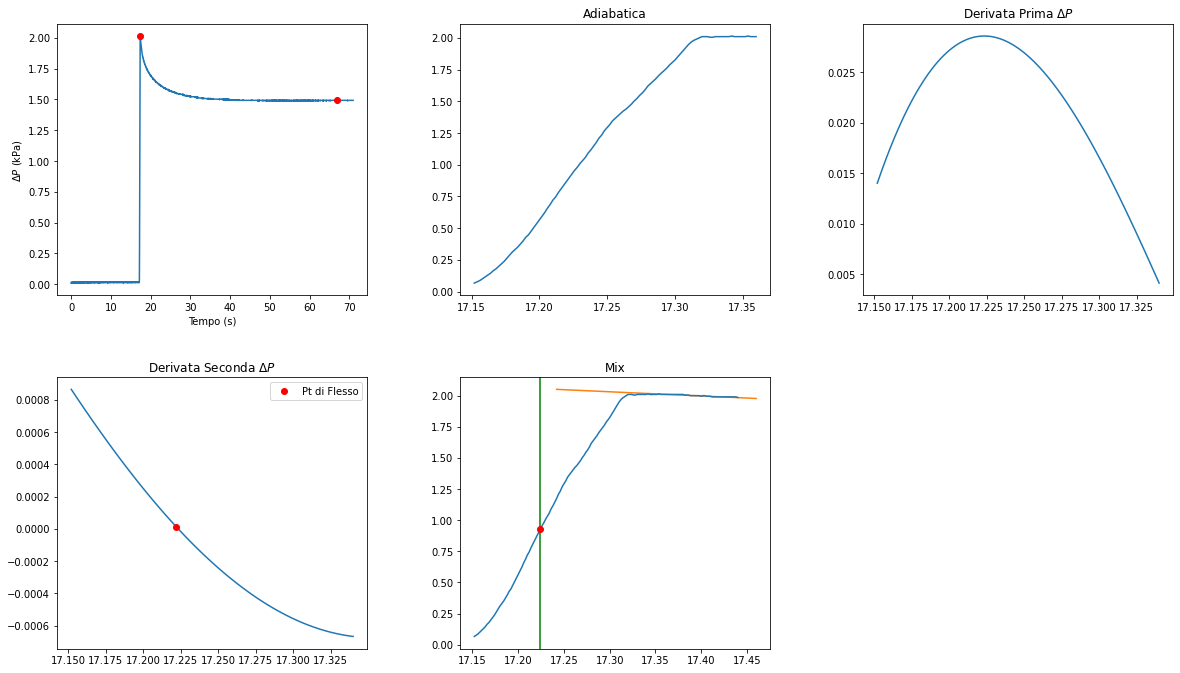

In [20]:
get_analytics(df[0],V0, vf[0],verbose=False,plot=True)

# Data Analysis

In [15]:
tb = np.array([ get_analytics(df[i],V0, vf[i],verbose=False) for i in range(0,len(df)-1) ]) # Array di V,DPs,DPt (devi data frame sotto)
tb = tb[tb[:, 0].argsort()] #ordino per colonna volume

pd.DataFrame(tb, columns=['Delta V', 'Delta P_s', 'Delta P_t', 'Errore Sistematico'])

,Delta V,Delta P_s,Delta P_t,Errore Sistematico
0,33.5,2.006897,1.484420,0.042031
1,36.5,1.357463,0.991241,0.009445
2,40.0,0.708029,0.493179,0.006271
3,40.5,1.020539,0.756859,0.010915
4,43.0,0.688497,0.507828,0.001684
5,43.5,0.649434,0.483413,0.008297
6,43.5,0.673848,0.498062,0.004037


# Fit Lineare
### Fit DPs

m         =  -0.1258
sigma(m)  =  0.0005
c         =  6.0554
sigma(c)  =  0.0214
cov(m, c) =  -0.0
rho(m, c) =  -0.9961


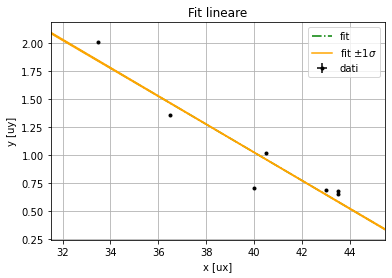

In [16]:

x=tb[:,0]
y=tb[:,1] 

uy=np.repeat(0.005,len(x))
ux=np.repeat(0.001,len(x))

ms, sms, cs, scs, covs,rhos= my.lin_fit(x, y, uy, "x [ux]", "y [uy]", plot=True,verbose=True ,setrange=False)


### Fit DPt

m         =  -0.0924
sigma(m)  =  0.0005
c         =  4.4487
sigma(c)  =  0.0214
cov(m, c) =  -0.0
rho(m, c) =  -0.9961


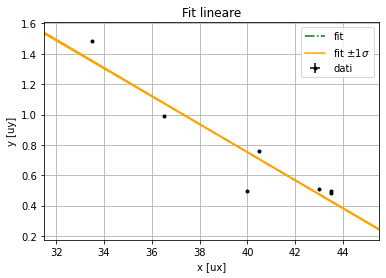

In [17]:
y=tb[:,2]
mt, smt, ct, sct, covt,rhot= my.lin_fit(x, y, uy, "x [ux]", "y [uy]", plot=True,verbose=True ,setrange=False)

# Plot dati e fit

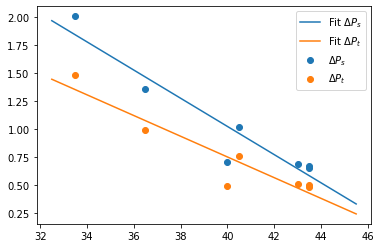

In [18]:
x = np.arange(tb[:,0][0]-1,tb[:,0][-1:]+3)
y = x*ms + cs
plt.plot(x,y,label="Fit $\Delta P_s$")
plt.scatter(tb[:,0],tb[:,1],label="$\Delta P_s$")

y = x*mt + ct
plt.plot(x,y,label="Fit $\Delta P_t$")
plt.scatter(tb[:,0],tb[:,2],label="$\Delta P_t$")

plt.legend()

# Coeff

In [19]:
coeff_adb = ms/mt
beta_t = -1/(V0*mt)
beta_s = -1/(V0*ms)

print(f"Coef Adiabatico: { coeff_adb.round(4) }")
print(f"B_t: {beta_t.round(4) }")
print(f"B_s: {beta_s.round(4) }")

Coef Adiabatico: 1.3609
B_t: 0.0093
B_s: 0.0068
